# Classification - BoW

This notebook discusses Multi-label classification methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in BoW representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

DATA_FOLDER = Path(MODELS_PATH) / 'classifier' / 'multi-label'
RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import BagOfWordsTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

transformer = BagOfWordsTransformer.load('tfidf', 'basic', 'lsa')
train = transformer.fit(X_train)

In [4]:
test = transformer.transform(X_test)

<a id='data_preparation'/>

## Data Preparation

In [5]:
def create_classifier(classifier, name):
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    #experimental_classifier.train(train, y_train)
    #experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [6]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 5197.749118566513s
Test: 0.2424333095550537s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02119009737160313      0.010036275695284159     0.22228133817009268      0.21717452640064489      0.20032571351797468      
micro                                                            0.2079468951555953       0.21145100292019722      0.20968431046760028      
macro                                                            0.09380888140377752      0.09316098609893282      0.09307942940521866      


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 50.28538942337036s
Test: 2140.179633140564s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012265003500286387     0.07061668681983072      0.41165860540104793      0.23603385731559856      0.28055805070919937      
micro                                                            0.6019417475728155       0.2285413375460769       0.3312977099236641       
macro                                                            0.5131395375253585       0.176832335382671        0.23821660636745123      


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [8]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 1117.8170819282532s
Test: 0.3091738224029541s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013351365111690957     0.06686819830713422      0.45175721195370533      0.36772067714631196      0.37287343115033567      
micro                                                            0.49703986317589793      0.36172148020489253      0.4187193483139841       
macro                                                            0.48601044388426756      0.26957232096937317      0.33324057807085966      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [9]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 906.3251893520355s
Test: 15.379284620285034s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011001081906701458     0.1037484885126965       0.5231015719467955       0.33797662232970577      0.382994882317736        
micro                                                            0.6787025096716596       0.32754081095313325      0.4418469486599935       
macro                                                            0.5979299784651937       0.22815847374258327      0.3022108888452403       


In [10]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 696.2354762554169s
Test: 15.634252071380615s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011302742951696048     0.08984280532043531      0.42209391374445787      0.2411870213623539       0.2873982265215639       
micro                                                            0.7375854214123007       0.23251472066637943      0.35357064861323434      
macro                                                            0.45796619016156065      0.1057096142570742       0.15412530045226597      


<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [11]:
from skmultilearn.problem_transform import ClassifierChain

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 1884.3577904701233s
Test: 93.59907412528992s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011104817666900019     0.10229746070133011      0.5316827891979041       0.3526259572752922       0.39563060209976775      
micro                                                            0.6582627898417373       0.3424769017186079       0.4505463362408288       
macro                                                            0.6007201094105111       0.24128041982625767      0.3161772221080595       


In [12]:
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Training: 1877.0981373786926s
Test: 97.10368871688843s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01128174123337364      0.09117291414752116      0.43144095122934295      0.25156590084643293      0.2973499548952995       
micro                                                            0.7258571428571429       0.24323806788261765      0.36437305030657247      
macro                                                            0.4423238790486163       0.10718615787356028      0.1550669859394562       


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [13]:
from skmultilearn.problem_transform import LabelPowerset

#create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

In [14]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [15]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

Training: 7216.436701059341s
Test: 2303.4878895282745s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01204480366575447      0.07787182587666264      0.45918178153970174      0.27838774687625956      0.32395011612061186      
micro                                                            0.6051870110384739       0.2703336684379338       0.3737260092653872       
macro                                                            0.4946745182761915       0.20874962139382877      0.27168533572230996      


<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [16]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Training: 34.25027012825012s
Test: 11618.217583656311s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02589002736587539      0.003990326481257557     0.1621742384983014       0.18084240225715437      0.152886936387541        
micro                                                            0.13700388819602377      0.1788022404136148       0.15513696496438287      
macro                                                            0.00898124372095179      0.01880286799175808      0.005268935934701219     


<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [17]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Training: 4273.65997338295s
Test: 144.77095413208008s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.010974352447018393     0.10290205562273277      0.5209310761789602       0.3258282950423217       0.3745261127425578       
micro                                                            0.6916605321274581       0.3148547082196371       0.4327258372261332       
macro                                                            0.60117794780349         0.21177337865693827      0.28453471676081227      


In [18]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Training: 4994.707603931427s
Test: 145.4162585735321s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01112009164386177      0.09407496977025392      0.4625574365175332       0.2726844014510278       0.32053261933552135      
micro                                                            0.724855186940495        0.2635837043419982       0.3865894330349307       
macro                                                            0.5283548206873624       0.14399050998117296      0.20694653606154112      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [19]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Training: 1310.2047111988068s
Test: 57.41558051109314s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011017628715076689     0.10532043530834341      0.5222511084240226       0.3333010882708585       0.3806341790682783       
micro                                                            0.6807478524507327       0.3224663698597348       0.4376299376299377       
macro                                                            0.6122387843302397       0.22113173484381288      0.29483968661552107      


In [20]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Training: 1556.626630783081s
Test: 57.6696240901947s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011079997454337173     0.09528415961305925      0.47043530834340985      0.2803143893591294       0.3281586725782615       
micro                                                            0.7219599336480796       0.2708602613815884       0.39392884494882685      
macro                                                            0.5295342388796899       0.1475712436827773       0.21061854668158173      


***Clustering***

In [21]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    edge_map = graph_builder.transform(y_train)
    return graph_builder

In [22]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [23]:
clusterer_igraph = get_clusterer()

<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [24]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Training: 7752.715445518494s
Test: 95.67275977134705s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011077451791510215     0.09528415961305925      0.4856650544135429       0.2898750503829101       0.33948638221915123      
micro                                                            0.7110141766630316       0.2809133993968117       0.40271772699197034      
macro                                                            0.5180233511292487       0.14676807160544678      0.20907349436946393      


In [25]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

Training: 1770.2690122127533s
Test: 111.61510348320007s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011062177814548463     0.10181378476420798      0.5261023780733576       0.34526803708182185      0.3886457335489984       
micro                                                            0.6674945075938485       0.33453013547800275      0.44569168952101534      
macro                                                            0.6026451701658421       0.2355506113576109       0.310237914978813        


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [26]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Training: 8083.252104997635s
Test: 97.90325284004211s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011077451791510215     0.09528415961305925      0.4856650544135429       0.2898750503829101       0.33948638221915123      
micro                                                            0.7110141766630316       0.2809133993968117       0.40271772699197034      
macro                                                            0.5180233511292487       0.14676807160544678      0.20907349436946393      


In [27]:
# DNF
#create_classifier(LabelSpacePartitioningClassifier(
#    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
#    clusterer = clusterer_igraph
#), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

<a id='evaluation'/>

## Evaluation

In [28]:
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths
paths = available_classifier_paths('tfidf')

In [29]:
evals = []
for path in paths:
    if '-' not in path.name:
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([str(clf), evaluation])

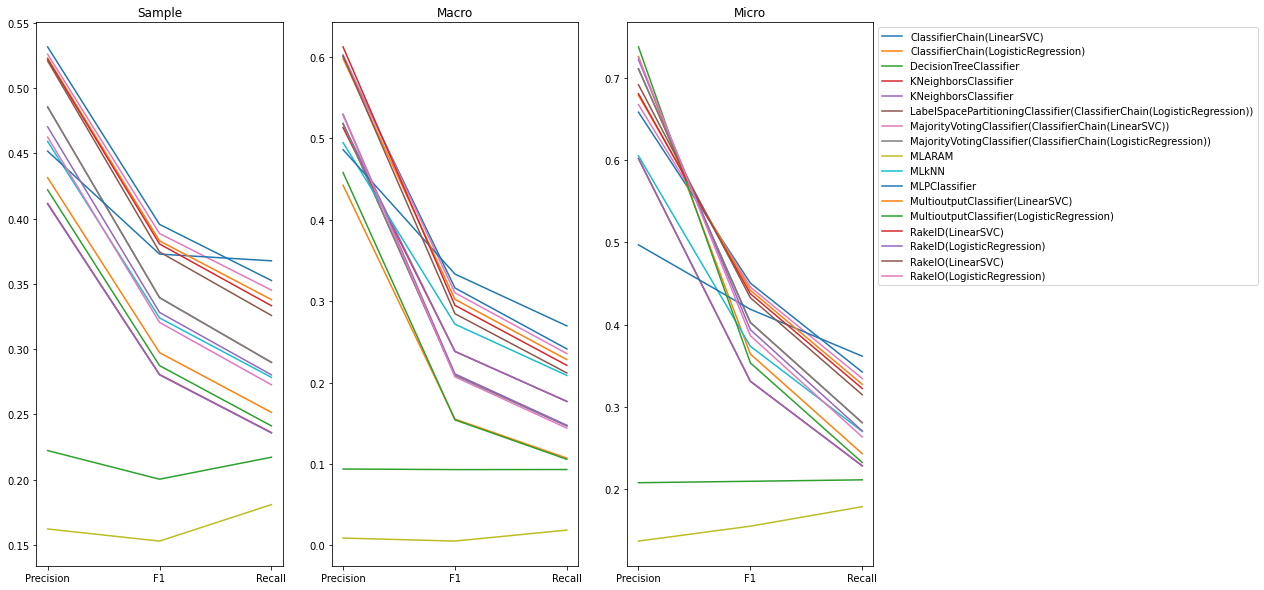

In [30]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [31]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [32]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [33]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    prediction = clf.predict(test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

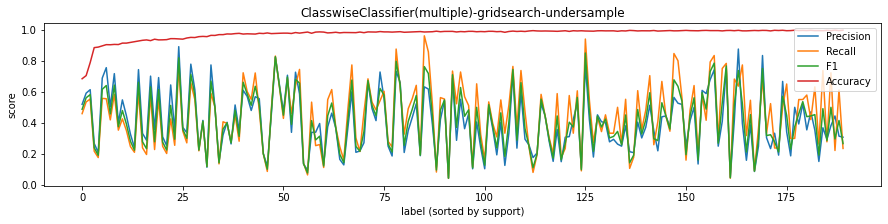

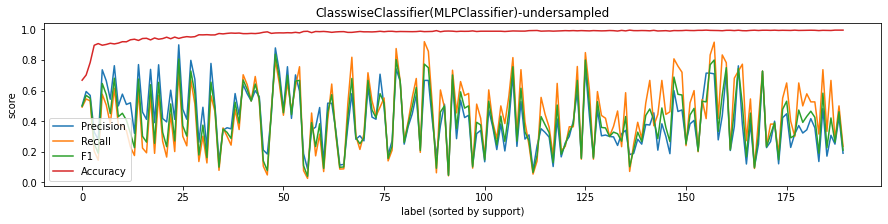

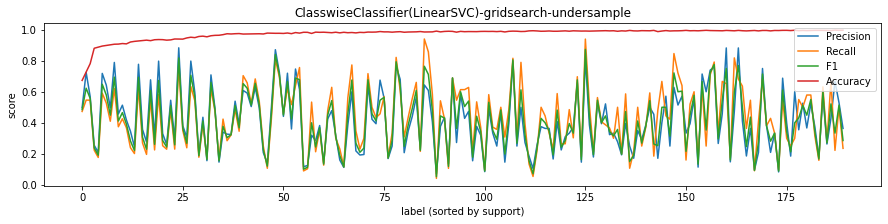

In [34]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()